# Model RESISC 45

In [1]:
import os
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import logging
import contextlib
import random
import platform
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

logger = logging.getLogger('train')
logger.setLevel(logging.INFO)

print(platform.platform())  # print current platform

macOS-13.3.1-arm64-arm-64bit


## Set constants

In [2]:
DIRPATH = "/Users/cristianion/Desktop/satimg_data/NWPU-RESISC45"

LABELS = [
    'forest',
    'railway_station',
    'tennis_court',
    'basketball_court',
    'river',
    'storage_tank',
    'harbor',
    'terrace',
    'thermal_power_station',
    'golf_course',
    'runway',
    'roundabout',
    'bridge',
    'industrial_area',
    'baseball_diamond',
    'mobile_home_park',
    'overpass',
    'church',
    'chaparral',
    'railway',
    'stadium',
    'medium_residential',
    'sea_ice',
    'intersection',
    'lake',
    'palace',
    'airplane',
    'cloud',
    'sparse_residential',
    'airport',
    'snowberg',
    'parking_lot',
    'commercial_area',
    'rectangular_farmland',
    'island',
    'beach',
    'circular_farmland',
    'dense_residential',
    'ship',
    'mountain',
    'desert',
    'freeway',
    'meadow',
    'wetland',
    'ground_track_field',
]

K_FOLDS = 5

In [3]:
print(len(LABELS))  # number of expected labels

45


# Prepare dataset

In [4]:
filelist = [(f"{DIRPATH}/{f}", LABELS[LABELS.index(f)]) for f in os.listdir(DIRPATH) if f in LABELS]
df = pd.DataFrame(filelist, columns=['dirpath', 'label'])

In [5]:
df.head()

,dirpath,label
0,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,forest
1,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,railway_station
2,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,tennis_court
3,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,basketball_court
4,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,river


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   dirpath  45 non-null     object
 1   label    45 non-null     object
dtypes: object(2)
memory usage: 852.0+ bytes


Conclusions
- 45 directories found corresponding to 45 labels

In [7]:
data = []
for i, DIRPATH in enumerate(df["dirpath"]):
    images = os.listdir(DIRPATH)
    images = [f"{DIRPATH}/{img}" for img in images]
    rows = [(img, df['label'][i]) for img in images]
    data.extend(rows)
data = pd.DataFrame(data, columns=["imgpath", "label"])

In [8]:
data.head()

,imgpath,label
0,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,forest
1,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,forest
2,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,forest
3,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,forest
4,/Users/cristianion/Desktop/satimg_data/NWPU-RE...,forest


In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31500 entries, 0 to 31499
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   imgpath  31500 non-null  object
 1   label    31500 non-null  object
dtypes: object(2)
memory usage: 492.3+ KB


Conclusions:
- 31500 annotated images

In [10]:
data['label'].value_counts()

label
forest                   700
intersection             700
palace                   700
airplane                 700
cloud                    700
sparse_residential       700
airport                  700
snowberg                 700
parking_lot              700
commercial_area          700
rectangular_farmland     700
island                   700
beach                    700
circular_farmland        700
dense_residential        700
ship                     700
mountain                 700
desert                   700
freeway                  700
meadow                   700
wetland                  700
lake                     700
sea_ice                  700
railway_station          700
medium_residential       700
tennis_court             700
basketball_court         700
river                    700
storage_tank             700
harbor                   700
terrace                  700
thermal_power_station    700
golf_course              700
runway                   700
roundabo

**Conclusions**:
- Each category of the 45 categories has 700 samples

## Sample subset of images from dataset

- show a subset of the images
- select some random labels (max 5 labels)
- show 5 images for each label to show variance
- contains varying spatial resolution ranging from 20cm to more than 30m/px.

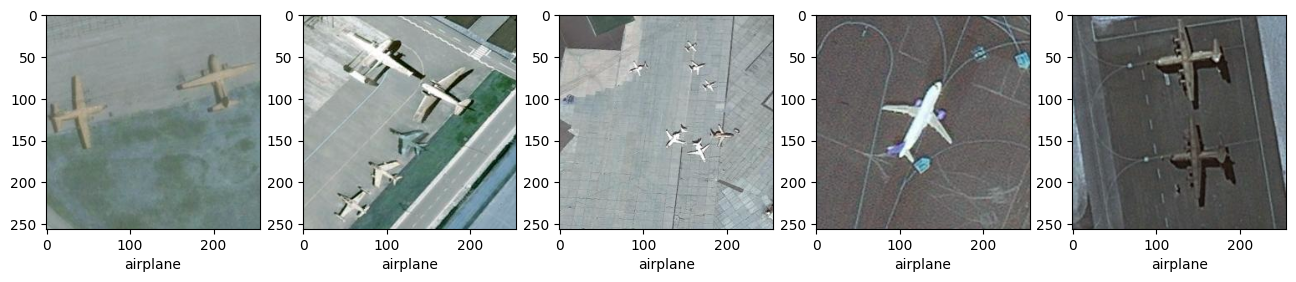

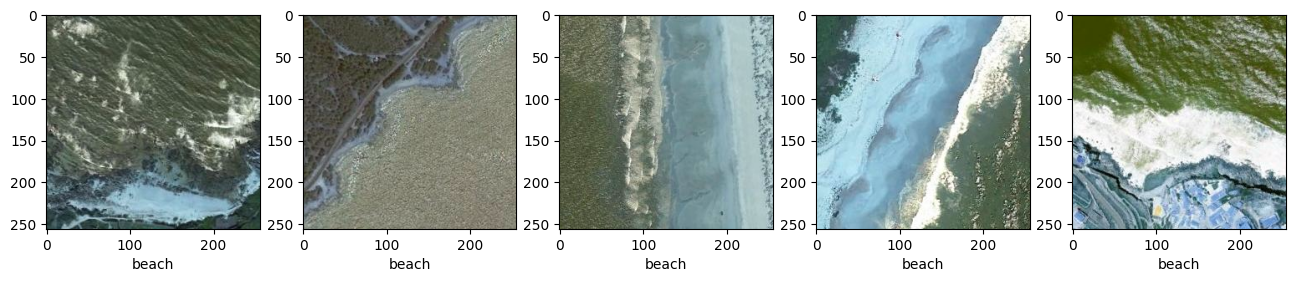

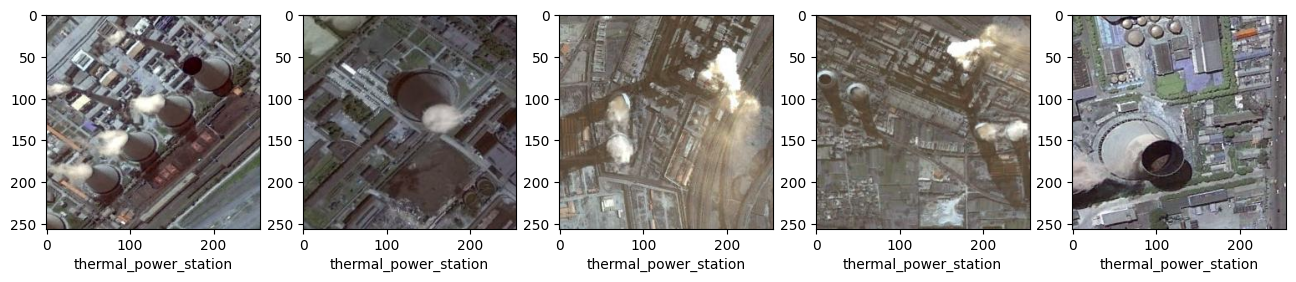

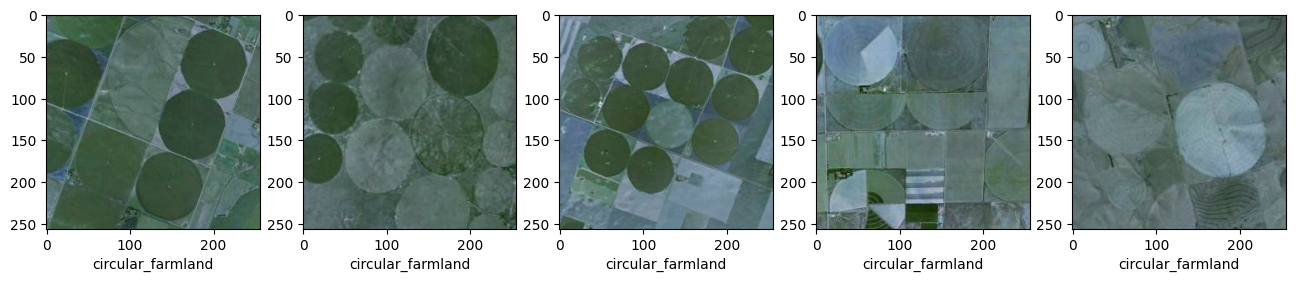

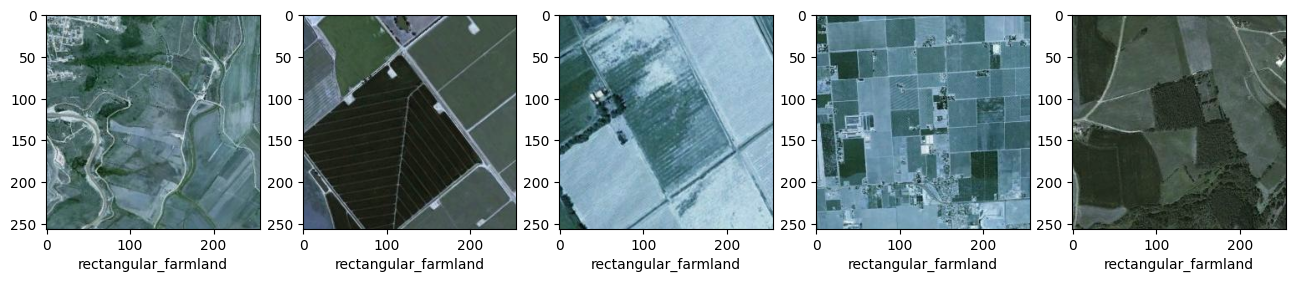

In [11]:
random_labels = random.sample(LABELS, min(5, len(LABELS)))
for label in random_labels:
    airplane_dataset = data[data['label'] == label].imgpath
    img_airplane = airplane_dataset.tolist()
    p1 = []
    for img in img_airplane[:5]:
        x = cv2.imread(img)
        p1.append(x)
    
    plt.figure(figsize=(16,10))
    for i in range(1,6):
        plt.subplot(2, 5, i)
        plt.grid(False)
        plt.imshow(p1[i-1])
        plt.xlabel(label)
    plt.show()

Conclusion
- Images have a resolution of 256 by 256 and 3 channels (RGB)

##  Partition dataset into folds
- add 5-fold for each sample (1,2,3,4,5): 1st 20%, 2nd 20%, etc.
- save current dataset on disk

In [12]:
# - add label index for training
label_index = []
for lab in data.label:
    label_index.append(LABELS.index(lab))
data['label_index'] = label_index

In [13]:
def parition_dataset(data, folds=5):
    # partition the dataset into folds
    parition_size = int(100 / folds)
    data = data.sample(frac=1).reset_index(drop=True)  # resample dataset randomly.
    folds = []
    n = len(data['label_index'])
    fold = 0
    for i in range(n):
        if ((i / n) * 100) % parition_size == 0:  # folds are %20, for 80% train and 20% val in 5-fold;
            fold += 1
        folds.append(fold)
    data['fold'] = folds
    data.sort_values(by=['label_index'], inplace=True)  # sort values
    return data


In [14]:
data = parition_dataset(data, folds=K_FOLDS)

In [15]:
data.to_csv("dataset_resisc45.csv", index=False)  # save dataset on disk

## Data load

In [16]:
df = pd.read_csv("dataset_resisc45.csv")

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31500 entries, 0 to 31499
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   imgpath      31500 non-null  object
 1   label        31500 non-null  object
 2   label_index  31500 non-null  int64 
 3   fold         31500 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 984.5+ KB


In [18]:
df["fold"].value_counts()

fold
5    6300
1    6300
3    6300
2    6300
4    6300
Name: count, dtype: int64

- 6300 samples in each fold.

## Train dataset loader

In [19]:
# Dataset loader
import enum

class DatasetTypes(enum.Enum):
    train = "train"
    val = "val"
    test = "test"


RES_X = 256
RES_Y = 256

class DatasetResisc45(Dataset):
    def __init__(self, dataset_file, dataset_type=None, val_fold=None, shuffle=False, transform=None, target_transform=None):
        df = pd.read_csv(dataset_file)
        if shuffle:
            df = df.sample(frac=1).reset_index(drop=True)
        folds = list(df["fold"].unique())  # get all folds
        if val_fold:
            if val_fold not in folds:
                raise Exception("Fold not found.")
            if dataset_type == DatasetTypes.train:
                df.drop(index=df[df["fold"] == val_fold].index, inplace=True)  # drop the validation fold
            elif dataset_type == DatasetTypes.val:
                df = df[df["fold"] == val_fold]  # keep only the validation fold in dataset
        self.img_labels = df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = self.img_labels.iloc[idx, 0]
        image = cv2.imread(img_path)
        image = cv2.resize(image, dsize=(RES_Y, RES_X))
        image = image - 128.5
        image = np.moveaxis(image, -1, 0).astype(np.float32) / 255.0  # move channels first (3 x RES_Y x RES_X)
        label_index = self.img_labels.iloc[idx, 2]
        label = np.zeros(len(LABELS), dtype=np.float32)
        label[label_index] = 1.0
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


# Classification problem

- 5-fold cross validation
- one-vs-all
- softmax

In [20]:
# find CUDA / MPS / CPU device
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using mps device


## Neural Networks Algorithms

In [21]:
from torch import nn

# Define model architecture
# need to implement dimensions checking!

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(RES_Y * RES_X * 3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, len(LABELS))
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class SatAlexNet(nn.Module):
    def __init__(self, num_channels=3):
        super(SatAlexNet, self).__init__()

        # add 1x1 conv with stride 1
        # add 3x3 conv with stride 2 in first layer
        
        # 1. initialize first set of CONV => RELU => POOL layers
        self.conv1 = nn.Conv2d(in_channels=num_channels, out_channels=50, kernel_size=(7, 7), stride=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))
        
        # 2. initialize second set of CONV => RELU => POOL layers
        self.conv2 = nn.Conv2d(in_channels=50, out_channels=100, kernel_size=(3, 3))
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))

        # 3. initialize second set of CONV => RELU => POOL layers
        self.conv3 = nn.Conv2d(in_channels=100, out_channels=200, kernel_size=(3, 3))
        self.relu3 = nn.ReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2))

        # 4. initialize second set of CONV => RELU => POOL layers
        self.conv4 = nn.Conv2d(in_channels=200, out_channels=200, kernel_size=(3, 3))
        self.relu4 = nn.ReLU()

        # 5. initialize second set of CONV => RELU => POOL layers
        self.conv5 = nn.Conv2d(in_channels=200, out_channels=100, kernel_size=(3, 3))
        self.relu5 = nn.ReLU()
        
        self.flatten = nn.Flatten()
        
        # initialize first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=8100, out_features=1024)
        self.relu6 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=1024, out_features=len(LABELS))

    def forward(self, x):
        # pass the input through our first set of CONV => RELU =>
        # POOL layers
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.maxpool3(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv4(x)
        x = self.relu4(x)
        # pass the output from the previous layer through the second
        # set of CONV => RELU => POOL layers
        x = self.conv5(x)
        x = self.relu5(x)
        # flatten the output from the previous layer and pass it
        # through our only set of FC => RELU layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu6(x)
        x = self.fc2(x)
        return x

In [22]:
# create model
def create_model_on_device(model_class, *args, **kwargs):
    print(f"device: {device}")
    model = model_class(*args, **kwargs).to(device) # create model on device
    print(str(model))
    return model

In [23]:
demo_model = create_model_on_device(SatAlexNet, num_channels=3)

device: mps
SatAlexNet(
  (conv1): Conv2d(3, 50, kernel_size=(7, 7), stride=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (conv5): Conv2d(200, 100, kernel_size=(3, 3), stride=(1, 1))
  (relu5): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8100, out_features=1024, bias=True)
  (relu6): ReLU()
  (fc2): Linear(in_features=1024, out_features=45, bias=True)
)


In [24]:
loss_fn = nn.CrossEntropyLoss()

def train_one_epoch(dataloader, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    print("Started train.")
    size = len(dataloader.dataset)
    
    model.train()  # set model to train mode

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def val_one_epoch(dataloader, model):
    print("Started validation.")
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    model.eval() # set model to evaluation mode

    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            error = (nn.Softmax(dim=1)(pred).argmax(1) == y.argmax(1)).type(torch.float)
            correct += error.sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

## 5 Fold train validation

- trebuie sa reducem timpii de antrenament

In [25]:
def kfold_train():
    epochs = 5
    batch_size = 64
    
    for val_fold in range(K_FOLDS):
        print(f"Fold: {val_fold}\n------------------------------")
        model = create_model_on_device(SatAlexNet)
        train_set = DatasetResisc45("dataset_resisc45.csv", dataset_type=DatasetTypes.train, val_fold=val_fold)
        val_set = DatasetResisc45("dataset_resisc45.csv", dataset_type=DatasetTypes.val, val_fold=val_fold)
        train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
        val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_one_epoch(train_dataloader, model)
            val_one_epoch(val_dataloader, model)


In [26]:
def simple_train():
    model = create_model_on_device(SatAlexNet)
    train_set = DatasetResisc45("dataset_resisc45.csv", dataset_type=DatasetTypes.train, val_fold=5)
    val_set = DatasetResisc45("dataset_resisc45.csv", dataset_type=DatasetTypes.val, val_fold=5)
    train_dataloader = DataLoader(train_set, batch_size=64, shuffle=True)
    val_dataloader = DataLoader(val_set, batch_size=64, shuffle=False)

    epochs = 10
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_one_epoch(train_dataloader, model)
        val_one_epoch(val_dataloader, model)


In [27]:
simple_train()

device: mps
SatAlexNet(
  (conv1): Conv2d(3, 50, kernel_size=(7, 7), stride=(2, 2))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(50, 100, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1))
  (relu3): ReLU()
  (maxpool3): MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(200, 200, kernel_size=(3, 3), stride=(1, 1))
  (relu4): ReLU()
  (conv5): Conv2d(200, 100, kernel_size=(3, 3), stride=(1, 1))
  (relu5): ReLU()
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=8100, out_features=1024, bias=True)
  (relu6): ReLU()
  (fc2): Linear(in_features=1024, out_features=45, bias=True)
)
Epoch 1
-------------------------------
Started train.
loss: 3.807287  [   64/ 6300]
S

## Bias-variance trade 
- work in progress..

In [ ]:
%matplotlib ipympl

epochs = np.arange(0, 20, 1)
train_losses = []
val_losses = []
for epoc in epochs:
    train_losses.append(random.random())
    val_losses.append(random.random())

x = epochs
y = train_losses
y2 = val_losses

fig, ax = plt.subplots()
ax.plot(x, y)
ax.plot(x, y2)
#specify axis tick step sizes
_ = plt.xticks(np.arange(min(x), max(x)+1, 1))
_ = plt.yticks(np.arange(0, max(y)+0.1, 0.1))

ax.set_title("train loss")
plt.show()

## Confusion matrix

- one vs all
- precision, recall, f1